In [1]:
import os
from pathlib import Path
#from flame import Machine
import flame
from flame import Machine #Machine() not found without this line
import flame_utils
import numpy as np
import matplotlib.pyplot as plt
import labframePlotFun
%matplotlib inline
#%matplotlib qt #for showing graphs in second window

In [2]:
#Linking to flame/data folder in cwd, and establishing lattice file (.lat)
# latpath definition seems to assume rea-files/ and phantasy-machines/ is in same folder...

#current working dir
cwd = os.getcwd()

#Get path of directory containing flame module
#  (todo: if not found, search rea-files parent directory,
#  or rea3/data/CrispAnalysis/phantasy-machines)
flamedir = os.path.dirname(os.path.abspath(flame.__file__))
# if found, create link in cwd to flame/data folder
if os.path.isfile(flamedir):
    flamedata = flamedir + '/data'
    os.unlink(cwd + '/data')
    os.symlink(flamedata, cwd + '/data')

# define '.lat' latfile
#latfile = "ReA3_JENSA.lat"
#latfile_handle = open(cwd + '/' + latfile, 'rb')
latfile = "baseline_gpl_fully_corrected.lat"
latpath = str(Path(cwd).parent) + '/phantasy-machines/ReA/GPL/' + latfile
latfile_handle = open(latpath, 'rb')
latpath

'/projects/rea3/data/CrispAnalysis/phantasy-machines/ReA/GPL/baseline_gpl_fully_corrected.lat'

In [3]:
# create FLAME machine
m = Machine(latfile_handle)

# create BeamState object
bs = flame_utils.BeamState(machine=m)

# create ModelFlame object
fm = flame_utils.ModelFlame()

In [4]:
# setup machine and state
fm.bmstate, fm.machine = bs, m

In [47]:
# setup observers and run flame model
obs = range(len(fm.machine))
r,s = fm.run(monitor=obs)

In [49]:
Ek_list = [i[1].ref_IonEk for i in r]
r[24][1].ref_IonEk

500376.7160938978

In [23]:
m.conf(0)['IonEk'] # Input beam energy in eV/u

500000.0

In [25]:
Ek_RFQ = 541000.0 # New RFQ outputs ~0.541 MeV/u
m.reconfigure(0, {'IonEk':Ek_RFQ})
m.conf()['IonEk']

500000.0

In [17]:
m.find(type='rfcavity') # find element index by element name

[24, 46, 53, 55, 62, 64, 71, 86, 93, 95, 97, 104, 106, 108, 115]

In [18]:
m.conf(24).keys() # Parameter keys of element

odict_keys(['Eng_Data_Dir', 'HdipoleFitMode', 'IonChargeStates', 'IonEk', 'IonEs', 'L', 'MpoleLevel', 'NCharge', 'P0', 'S0', 'aper', 'cavtype', 'datafile', 'f', 'name', 'phi', 'scl_fac', 'sim_type', 'type'])

In [30]:
####################
# Cavity Scan(s)   #
####################

In [31]:
# Cavity Name
m.conf(24)['name']

'REA_CK01:CAV_D1049'

In [10]:
# Initial Cav Ampl
ampl_ini = m.conf(24)['scl_fac']
ampl_ini

-9.10184

In [33]:
# Initial Cav Phase
pha_ini = m.conf(24)['phi']
pha_ini

270.242

In [39]:
# Check what's after
m.conf(25)['name']

'REA_CK01:CAV_DFT_D1049'

In [ ]:
##############################
# Establish state
# Run, get exit energy. (are vals at element before or after?)

In [40]:
# run simulation to just after 1st cavity
SA = m.allocState({})
rA = m.propagate(SA, 0, 25, observe=range(len(m))) # propagate up to quad we're scanning

In [45]:
energy_at_element = m.conf(25)

500000.0

In [36]:
# scan parameters by using single loop
b2lst = [-5.0, -7.5, -10, -12.5, -15] # Quad strengths
rlst = []
for b2 in b2lst:
    SB = SA.clone()
    m.reconfigure(307, {'B2':b2})
    rt = m.propagate(SB,307,360,observe=range(len(m))) # range(len(m)) is 0, 360
    rlst.append(rt)

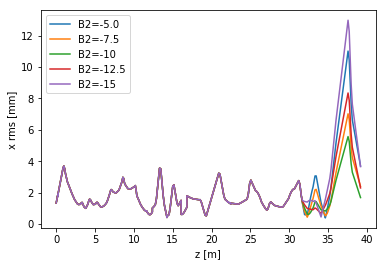

In [14]:
# plot the scan result

# get z-position and x-rms data from before scanned quad
zA = [s[1].pos for s in rA] # get z positions of elements
xA = [s[1].moment0_rms[0] for s in rA] # get the x rms size at location of elements

# append resulting x-rms data to pre-quad data
#  for a given run at quad strength b2lst
for b2,rt in zip(b2lst,rlst):
    zt = zA + [s[1].pos for s in rt] # join the history result
    xt = xA + [s[1].moment0_rms[0] for s in rt]
    plt.plot(zt, xt, label='B2='+str(b2))

plt.ylabel('x rms [mm]')
plt.xlabel('z [m]')
plt.legend(loc='best')
plt.show()